# Clustering

Another useful application from the field of unsupervised learning is clustering. Clustering involves dividing the data into subgroups, where members of each group should be as similar as possible to their own group members and as different as possible from members of other groups. The similarity of pairwise observations is evaluated using all variables. In the bottom two cells, we see the first observations of a dataset with two variables $x_1, x_2$. In total, this artificially generated dataset has $300$ observations, which can be divided relatively unambiguously into three clusters. In the graph on the left, we see what the data would look like without cluster assignment. In this case, we can identify the division into three clusters relatively well. However, as soon as we are dealing with more than $3$ variables in a dataset, the possibility of visual partitioning disappears. In addition, real data usually cannot be divided into clusters so clearly. In order to divide data into similar and dissimilar observations as well as possible, we first need one or more metrics on how to quantify similarity. Starting from this, various methos of clustering exist, and in this chapter we will look at the algorithms of K-means and hierarchical clustering as examples. Both algorithms are well suited to understand the principles of clustering, since the chosen procedure is relatively intuitive and comparatively easy to follow. 

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pylab as plt
import pandas as pd

X, clusters = make_blobs(n_samples=300, n_features=2, centers=3, random_state=42, cluster_std=2)
df = pd.DataFrame(X, columns=["x_1", "x_2"])
df.loc[:, "cluster"] = clusters
df.head()

,x_1,x_2,cluster
0,-7.798349,-8.579798,2
1,-8.600454,-7.649221,2
2,-0.864108,6.572599,0
3,4.204516,4.170723,1
4,-10.955876,-8.896282,2


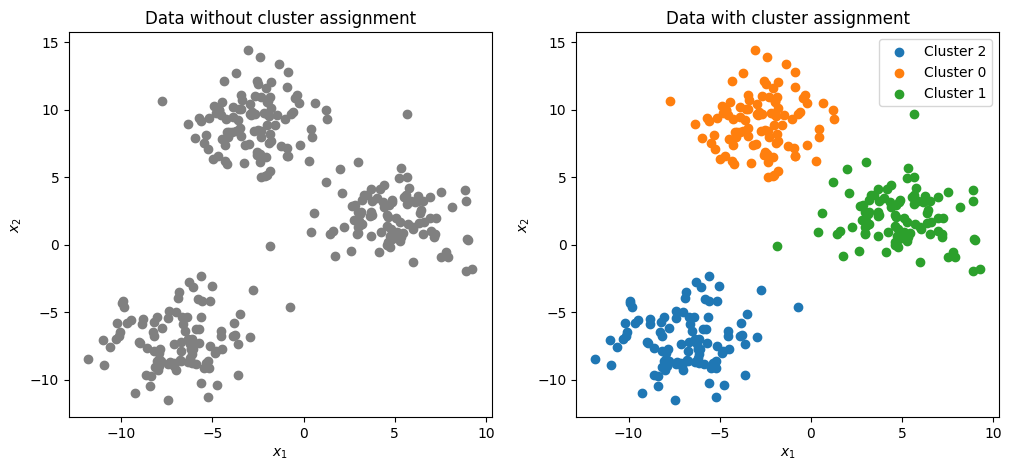

In [2]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].scatter(df.x_1, df.x_2, c = "grey")
for cluster in df.cluster.unique():
    df_tmp = df[df.cluster == cluster]
    axs[1].scatter(df_tmp.x_1, df_tmp.x_2, label = f"Cluster {cluster}")

axs[0].set_title("Data without cluster assignment")
axs[1].set_title("Data with cluster assignment")
axs[0].set_xlabel(r"$x_1$")
axs[0].set_ylabel(r"$x_2$")
axs[1].set_xlabel(r"$x_1$")
axs[1].set_ylabel(r"$x_2$")
axs[1].legend()

plt.show()

## Similarity of observations

More generally, in clustering we are dealing with a data set of $n$ observations measured by $p$ variables. Two observations $\boldsymbol{x}_i, \boldsymbol{x}_l$ are thus described by:

$$
\boldsymbol{x}_i = 
\begin{pmatrix}
x_{i1} \\
x_{i2} \\
\vdots \\
x_{ip} \\
\end{pmatrix} ~~~
\boldsymbol{x}_l = 
\begin{pmatrix}
x_{l1} \\
x_{l2} \\
\vdots \\
x_{lp} \\
\end{pmatrix}
$$

Since the two observations are vectors, one could use the distance between the vectors as their similarity or difference. The distance can be quantified by the Euclidean distance. This is denoted by:

$$
d \left(\boldsymbol{x}_i, \boldsymbol{x}_l \right) = \sqrt{ \sum_{j=1}^p \left(x_{ij} - x_{lj}\right)^2 }
$$

In the graph below, we consider three observations of a data set with two variables. The data are given with the following values and visualized as in the following cell.

In [3]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np


X = np.array([[0.5, 2], [1, 1], [2, 5]])
df = pd.DataFrame(X, columns = ["x_1", "x_2"], index = ["A", "B", "C"])
df.head()

,x_1,x_2
A,0.5,2.0
B,1.0,1.0
C,2.0,5.0


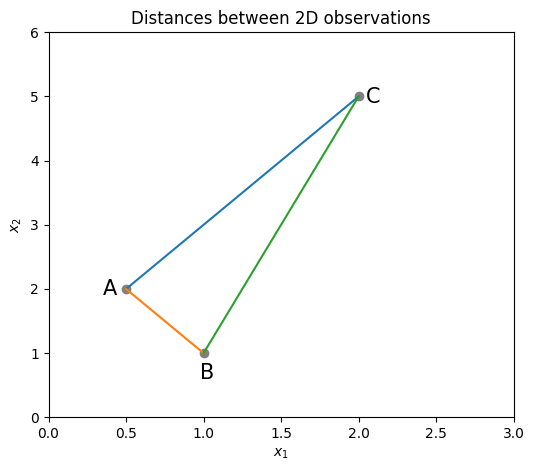

In [4]:
fig, ax = plt.subplots(figsize = (6, 5))
ax.scatter(X[:, 0], X[:, 1], c = "grey")
ax.plot([0.5, 2], [2, 5])
ax.plot([1, 0.5], [1, 2])
ax.plot([1, 2], [1, 5])
ax.text(0.35, 1.9, "A", size = 15)
ax.text(0.975, 0.6, "B", size = 15)
ax.text(2.05, 4.9, "C", size = 15)
ax.set_xlim((0, 3))
ax.set_ylim((0, 6))

ax.set_title("Distances between 2D observations")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
plt.show()

If we calculate the Euclidean distance for each pair, the following values result:

In [5]:
from sklearn.metrics.pairwise import euclidean_distances

pd.DataFrame(euclidean_distances(df), columns = ["A", "B", "C"], index = ["A", "B", "C"]).round(4)

,A,B,C
A,0.0000,1.1180,3.3541
B,1.1180,0.0000,4.1231
C,3.3541,4.1231,0.0000


If we had the goal of dividing these three data points into two clusters, it would be intuitive to assign data points A and B to one cluster and data point C to another cluster because the similarity (Euclidean proximity) between A and B is relatively high, but the proximity between A and C and B and C is relatively low. While we (or I) did this assignment based on Euclidean distance, the assignment was done manually. The task of cluster algorithms is to perform this assignment in an automated, reasonable and comprehensible way. However, it is not always necessary to fall back on the Euclidean distance. Further examples would be the Cosine-Similarity or the Manhatten-Similarity. Depending on the type of data, there are different advantages and disadvantages. 

Mathematically it holds for distance measures $d\left( \boldsymbol{x}_i, \boldsymbol{x}_l \right)$:

* $d\left( \boldsymbol{x}_i, \boldsymbol{x}_l \right) \geq 0 $ (non negativity)
* $d\left( \boldsymbol{x}_i, \boldsymbol{x}_l \right) = 0 \text{ nur falls } \boldsymbol{x}_i = \boldsymbol{x}_l$ (positive definitness)
* $d\left( \boldsymbol{x}_i, \boldsymbol{x}_l \right) = d\left( \boldsymbol{x}_l, \boldsymbol{x}_i \right)$ (symmetry resp. commutativity)
* $d\left( \boldsymbol{x}_i, \boldsymbol{x}_l \right) \leq d\left( \boldsymbol{x}_i, \boldsymbol{x}_k \right) + d\left( \boldsymbol{x}_k, \boldsymbol{x}_l \right)$ (triangle inequality)

## K-means clustering

In K-means clustering, the number $K$ of clusters is first determined manually. The cluster allocation $C_k$ for cluster $k$ is the set of data points in the corresponding cluster. For example, if $10$ data points are contained in a dataset, an allocation for $k = 3$ could be like:

$$
\begin{align}
C_1 = & \lbrace \boldsymbol{x}_4, \boldsymbol{x}_6, \boldsymbol{x}_8, \boldsymbol{x}_{10} \rbrace \\
C_2 = & \lbrace \boldsymbol{x}_2, \boldsymbol{x}_5, \boldsymbol{x}_7 \rbrace \\
C_3 = & \lbrace \boldsymbol{x}_1, \boldsymbol{x}_3, \boldsymbol{x}_9 \rbrace \\
\end{align}
$$

The aim of the algorithm is to perform this allocation in such a way that the average sum of the pairwise distances within the respective clusters is as small as possible. The squared Euclidean distance is used for quantification. Within a cluster, the average sum of all pairwise squared Euclidean distances is defined by:

$$
W \left( C_k \right) = \frac{1}{|C_k|} \sum_{i, l \in C_k} \sum_{j = 1}^p \left( x_{ij} - x_{lj} \right)^2
$$

$|C_k|$ is the set of all observations in cluster $k$. Using this definition, we can obtain the loss function of K-means clustering by:

$$
L\left( C_1, ..., C_k, X \right) = \sum_{k = 1}^K W \left( C_k \right) = \sum_{k = 1}^K \frac{1}{|C_k|} \sum_{i, l \in C_k} \sum_{j = 1}^p \left( x_{ij} - x_{lj} \right)^2
$$

Since there is no analytical solution for the minimization of the loss function, the loss function is minimized by iterative procedure. The K-means algorithm proceeds as follows:


K-means Clustering:
1. Each observation is randomly assigned a cluster at the beginning. 
2. Perform the following steps until the cluster assignments do not change. 
    1. determine the centroid for each cluster. The cluster centroid of the cluster $k$ is the average vector of the respective features for all observations within the cluster.
    2. assign the observations to the cluster with the smallest distance to the centroid.

In the following cells, we run the algorithm over two iterations. We can see well that after the random initialization, matching clusters are found relatively quickly and the cluster centroids move further apart. A critical aspect in practice is the sensitivity of the algorithm to the random assignment performed at the beginning. In addition, the clusters should be characterized and compared by their respective centroids. For example, if the algorithm runs multiple times, the cluster with the same centroid can be named cluster $C_0$ once and cluster $C_2$ the next time. This assignment is arbitrary, but the centroids found are characteristic. In addition, it is important to know that the data should be normalized before clustering, otherwise the Euclidean distance or squared Euclidean distance is more influenced by the variable with the higher numerical values. For example, if the values of two features are in the range $[0, 1]$ and $[0, 1000]$, a distance of $10^2$ of the second feature would dominate the quantification of the Euclidean distance compared to the maximum distance $1^2$ of the first feature, although this should probably be considered relatively small in relation to the total numerical range.

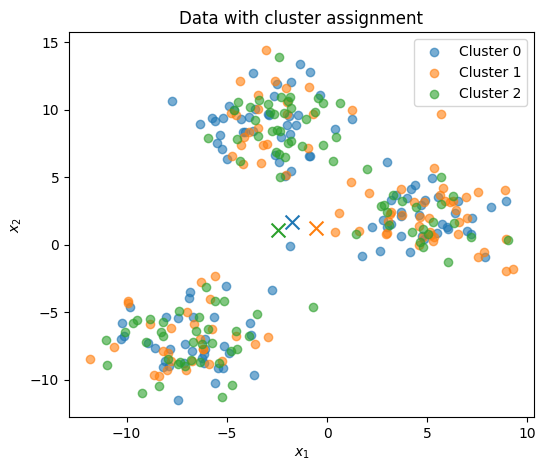

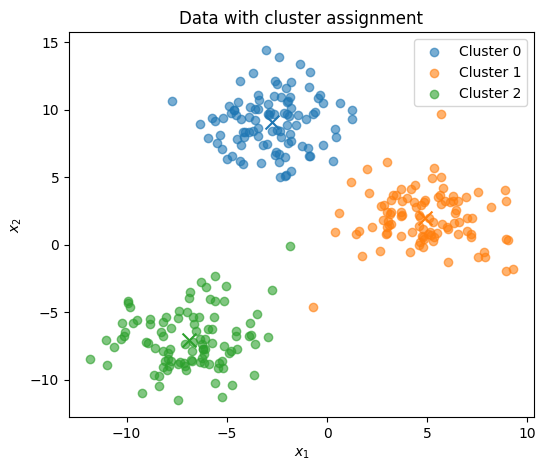

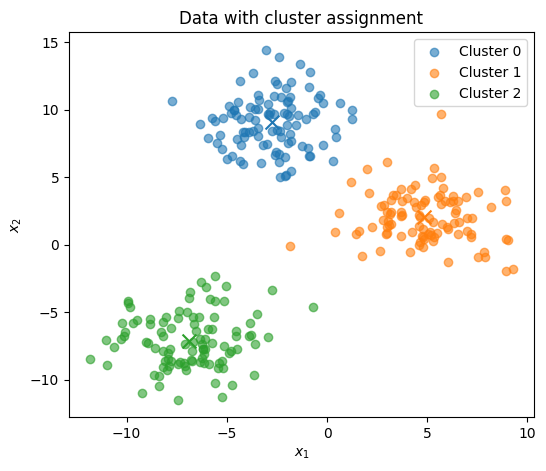

In [6]:
from sklearn.datasets import make_blobs
import matplotlib.pylab as plt
from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd
import random


colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
X, clusters = make_blobs(n_samples=300, n_features=2, centers=3, random_state=42, cluster_std=2)
df = pd.DataFrame(X, columns=["x_1", "x_2"])
random.seed(42)
df.loc[:, "est_cluster"] = random.choices([0, 1, 2], k = df.shape[0])

for i in range(3):
    cluster_centroids = []

    for cluster in [0, 1, 2]:
        df_tmp = df[df.est_cluster == cluster]
        df_tmp = df_tmp.drop(["est_cluster"], axis = 1)
        cluster_centroids.append(df_tmp.mean())
    cluster_centroids = np.array(cluster_centroids)

    fig, ax = plt.subplots(figsize = (6, 5))
    for i, cluster in enumerate([0, 1, 2]):
        df_tmp = df[df.est_cluster == cluster]
        ax.scatter(df_tmp.x_1, df_tmp.x_2, label = f"Cluster {cluster}", c = colors[i], alpha = 0.60)
        ax.scatter(cluster_centroids[i][0], cluster_centroids[i][1], marker = "x", c = colors[i], s = 100)

    ax.set_title("Data with cluster assignment")
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.legend()

    plt.show()

    df.loc[:, "est_cluster"] = np.argmin(euclidean_distances(df.drop(["est_cluster"], axis = 1).values, cluster_centroids), axis = 1)

After cluster allocation, the K-means algorithm has to find the best value for $K$. For this purpose, the quality of the allocation found in each case must be quantified and compared with the other allocations. An example for a corresponding measure is the silhouette score of an observation. Here, on the one hand, the average squared Euclidean distance of the $i$-th observation to all other observations within the cluster of $i$ is determined.

$$
a(i) = \frac{1}{| C_k| - 1} \sum_{l \in C_k, l \neq i} \sum_{j = 1}^p \left( x_{ij} - x_{lj} \right)^2, i \in C_k
$$

In addition, the average squared Euclidean distance of the $i$th observation to the nearest cluster is determined:

$$
b(i) = \min_{C_q} \frac{1}{| C_q| - 1} \sum_{l \in C_q, i \neq l} \sum_{j = 1}^p \left( x_{ij} - x_{lj} \right)^2, i \not\in C_q
$$

The silhouette score for the $i$th observation is given by:

$$
S(i) = \frac{b(i) - a(i)}{\max \lbrace a(i), b(i)\rbrace}
$$

The value is in the interval $[-1, 1]$, where a value close to $1$ signals very good separation of the observation by its cluster assignment, while a negative value suggests that this observation is on average closer to the observations of the nearest cluster. Averages over a cluster can be used as a cluster-specific metric, while the average over all observations can be used as a metric for the entire cluster classification. In the left plot of the next graph, we see the average silhouette score over all clusters for a different number of clusters. We can see that the actual number of clusters $K=3$ would also be identified using this metric. The estimated cluster assignments for $K=3$ can be seen in the right plot.

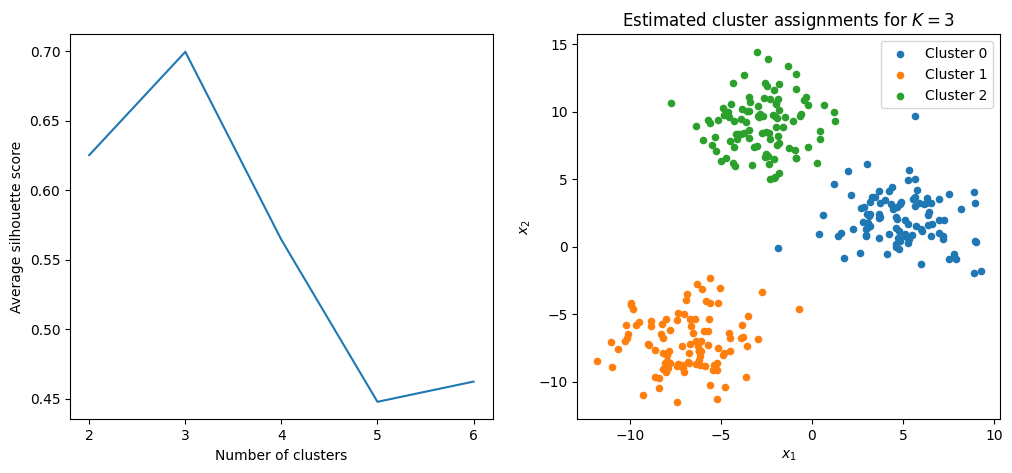

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
import matplotlib.pylab as plt


X, clusters = make_blobs(n_samples=300, n_features=2, centers=3, random_state=42, cluster_std=2)
df = pd.DataFrame(X, columns=["x_1", "x_2"])

scores = []
max_clusters = 7
for n_cluster in range(2, max_clusters): 
    kmeans = KMeans(n_clusters = n_cluster, n_init = "auto", random_state = 42)
    kmeans.fit(X)
    silhouette_scores = silhouette_samples(X, kmeans.labels_, metric = "euclidean")
    scores.append(silhouette_scores.mean())

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].plot(scores)
axs[0].set_xticks([0, 1, 2, 3, 4], ["2", "3", "4", "5", "6"])
axs[0].set_xlabel("Number of clusters")
axs[0].set_ylabel("Average silhouette score")


kmeans = KMeans(n_clusters=3, n_init = "auto")
kmeans.fit(X)
df.loc[:, "cluster"] = kmeans.labels_
for i in range(3):
    df[df.cluster == i].plot.scatter(x = "x_1", y = "x_2", c = colors[i], ax = axs[1], label = f"Cluster {i}")
axs[1].set_xlabel(r"$x_1$")
axs[1].set_ylabel(r"$x_2$")
axs[1].set_title(r"Estimated cluster assignments for $K=3$")

plt.show()

An even more differentiated graphical view of the clustering quality can be generated if we visualize the silhouette scores in ascending order for each estimated cluster. In this way, we can see in which clusters the highest scores occur and in which clusters, on the other hand, individual less good assignments take place. We also look at the appropriate graph for our example and see that the cluster in the lower left corner has the highest silhouette scores. This makes sense, since it is further away from the other two clusters, which results in a better delineation. We also see that a negative silhouette score is realized for the cluster in the middle. This is the single data point that is very close to the cluster in the left corner. The idea of the Silhouette Score can of course be adapted for other distance measures. In addition, other metrics can be used to evaluate the cluster assignment. However, the operation of most metrics is similar in principle to the Silhouette Score, which is why we refrain from further illustrations.

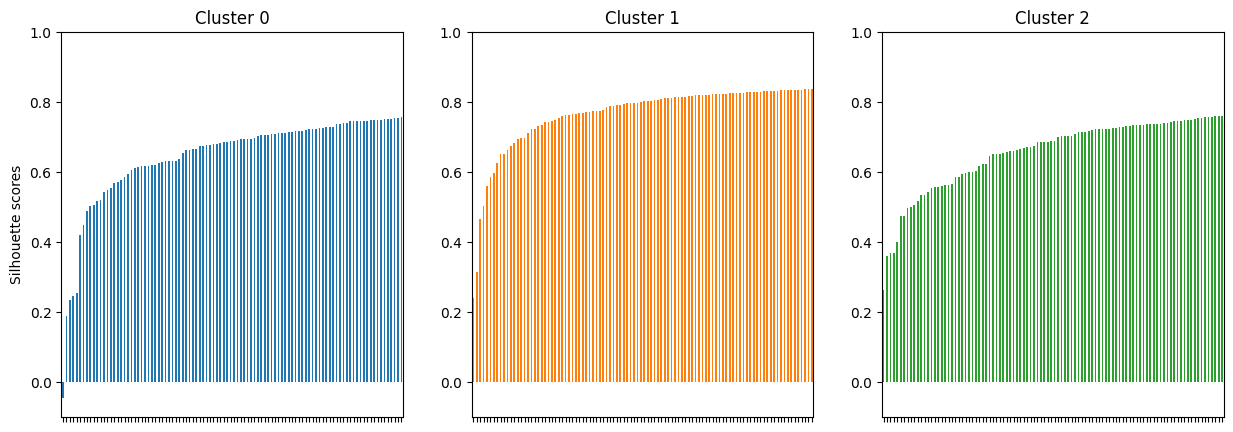

In [8]:
distances = euclidean_distances(X)
silhouette_samples(distances, kmeans.labels_)
df.loc[:, "silhouette_scores"] = silhouette_samples(distances, df.cluster.values)


fig, axs = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3):
    df[df.cluster == i].sort_values(by = "silhouette_scores").plot.bar(y = "silhouette_scores", ax = axs[i], legend = False, title = f"Cluster {i}", color = colors[i])
    xticks = axs[i].get_xticks()
    axs[i].set_xticklabels([""]*len(xticks))
    axs[i].set_ylim((-0.1, 1))
axs[0].set_ylabel("Silhouette scores")
plt.show()

## Hierarchical clustering

To get an insight into how clusters can be formed in an alternative way, we still consider hierarchical clustering. At the beginning, each observation is interpreted as a cluster. In the course of the algorithm, observations that are as similar as possible are merged into new clusters (while the original clusters of these observations are no longer considered as existing clusters) until the number of desired clusters is reached. Thus, the commonality to K-means clustering is the necessary specification of the number of clusters. In contrast to K-means clustering, the clusters are not created by directly minimizing an objective function, but by successively merging the existing clusters. Depending on the type of merging, this can be equivalent to minimization, yet the approach is different. 

In the cell below, let us consider five observations and their pairwise Euclidean distances. In the first step, it is relatively easy to see that the two clusters (observations) with indexes $0$ and $1$ have the smallest distance, thus creating a new cluster from these two points. Thus, after this step, one has $4$ clusters. Three with one observation each and one cluster with the two observations $0, 1$. 

In [9]:
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import euclidean_distances


colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
X, clusters = make_blobs(n_samples=300, n_features=2, centers=3, random_state=42, cluster_std=2)
df = pd.DataFrame(X, columns=["x_1", "x_2"])

print("Observations:")
print(df.head())
print("")
print("Pairwise euclidean distances:")
print(pd.DataFrame(euclidean_distances(X[:5]), columns = list(range(5))))

Observations:
         x_1       x_2
0  -7.798349 -8.579798
1  -8.600454 -7.649221
2  -0.864108  6.572599
3   4.204516  4.170723
4 -10.955876 -8.896282

Pairwise euclidean distances:
           0          1          2          3          4
0   0.000000   1.228555  16.663698  17.511270   3.173348
1   1.228555   0.000000  16.189849  17.426369   2.665179
2  16.663698  16.189849   0.000000   5.608918  18.469707
3  17.511270  17.426369   5.608918   0.000000  20.014598
4   3.173348   2.665179  18.469707  20.014598   0.000000


In order to determine the similarity between clusters that contain more than one observation, it is necessary to define how this step is performed. For this purpose, the concept of linkage exists, which provides different definitions for determining cluster similarity. Examples of different types of linkage determination would be:

* Single: Choose the smallest pairwise distance between observations $i$ of cluster $k$ and observations $j$ of cluster $\tilde{k}$.
* Complete: choose the largest pairwise distance between observations $i$ of cluster $k$ and observations $j$ of cluster $\tilde{k}$
* Average: determine the average of all pairwise distances between observations $i$ of cluster $k$ and observations $j$ of cluster $\tilde{k}$.

With a chosen linkage definition, the algorithm of Hierarchical Clustering is generally described as follows:

Hierarchisches Clustering:
1. Each observation is interpreted as a cluster at the beginning.
2. Perform the following steps for a chosen distance and linkage measure until $K$ clusters have been formed:
    1. Determine the pairwise cluster linkages for all clusters.
    2. Merge the two clusters with the least linkage into one cluster. 

For a better understanding, we consider the hierarchical clustering for the five data points of the example and the single linkage step by step.

Step 1: Five observations, each is counted as a cluster, we have five clusters with one observation each: 

$$
C_0 = \lbrace \boldsymbol{x}_0 \rbrace, C_1 = \lbrace \boldsymbol{x}_1 \rbrace, C_2 = \lbrace \boldsymbol{x}_2 \rbrace, C_3 = \lbrace \boldsymbol{x}_3 \rbrace, C_4 = \lbrace \boldsymbol{x}_4 \rbrace
$$

Step 2: Merge the $i=0$ and $i=1$ observations into clusters with index $i=5$, since they have the smallest Euclidean distance of $1.23$. The new cluster has $2$ observations and index $i=5$: we obtain the following clusters: 

$$
C_2 = \lbrace \boldsymbol{x}_2 \rbrace, C_3 = \lbrace \boldsymbol{x}_3 \rbrace, C_4 = \lbrace \boldsymbol{x}_4 \rbrace, C_5 = \lbrace \boldsymbol{x}_1, \boldsymbol{x}_2 \rbrace
$$

Step 3: In the above example, we use the single linkage method to merge the clusters. Therefore, we only need to check which next two values have the smallest distance. This is true for the original observations $i=1, i=4$ with a distance of $2.67$. Since $i=1$ is already included in the new cluster with index $i = 5$, we need to merge this cluster with observation $i=4$. A new cluster is formed from clusters $C_4, C_5$ whose index is $i=6$. 

$$
C_2 = \lbrace \boldsymbol{x}_2 \rbrace, C_3 = \lbrace \boldsymbol{x}_3 \rbrace, C_6 = \lbrace \boldsymbol{x}_1, \boldsymbol{x}_2, \boldsymbol{x}_4 \rbrace
$$

Step4: The next smallest Euclidean distance would be the value $3.17$ between the original observations $i=0, i=4$. These are already connected by the previous step in cluster $C_6$, so we jump straight to the next smaller value of $5.61$. This refers to the original observations $i=2, i=3$, which are not yet in a cluster, so the new cluster $C_7$ is formed from these two observations.

$$
C_6 = \lbrace \boldsymbol{x}_1, \boldsymbol{x}_2, \boldsymbol{x}_4 \rbrace, C_7 = \lbrace \boldsymbol{x}_2, \boldsymbol{x}_3 \rbrace
$$

Step 5: The next smallest Euclidean distance is the value $16.19$ between the original observations $i=1, i=3$. Since these observations are in different clusters $C_6, C_7$, they are merged to the cluster with all observations in the last step.

A visual form of hierarchical clustering is given by dendograms, which visualize the pairwise mergers. In the next graph we see the five observations of our example and the corresponding dendogram of steps 1-5. With a desired number of clusters, the clusters can be extracted from the information of the dendogram. If the dendogram is visualized from bottom to top, as we did, $K$ clusters result from a horizontal cut through the dendogram, leaving $K$ separate branches.

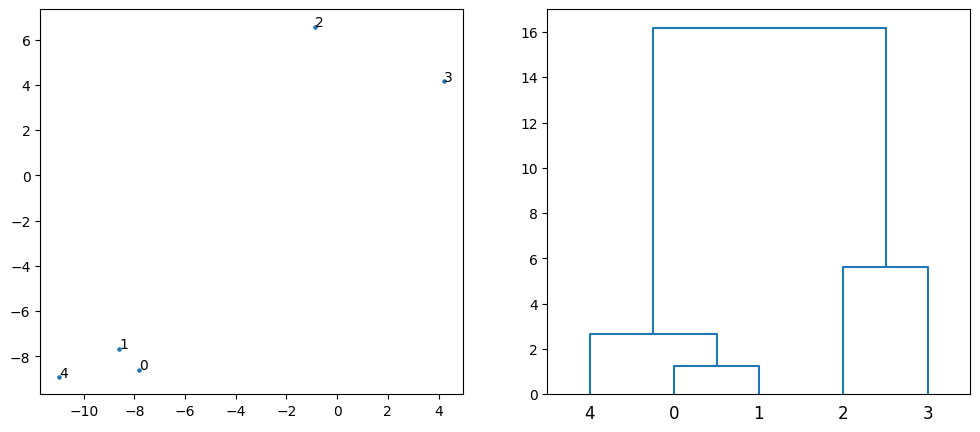

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
import matplotlib.pylab as plt
import pandas as pd


colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
X, clusters = make_blobs(n_samples=300, n_features=2, centers=3, random_state=42, cluster_std=2)
df = pd.DataFrame(X, columns=["x_1", "x_2"])

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].scatter(X[:5, 0], X[:5, 1], s = 5)
for i in range(5):
    axs[0].text(X[i, 0], X[i, 1], i)
Z = linkage(X[:5], method = "single")
dendrogram(Z, color_threshold = 0,  ax = axs[1])
plt.show()

Both the number of clusters and the linkage definition chosen affect the clustering. For this purpose, we consider the clusters found for the data already used in K-means clustering with $K=3$ and the variants of linkage definition provided in the sklearn module. We can definitely see some significant differences. In particular, using single-linkage produces a partitioning that is significantly different from the originally generated partitioning. Such sensitivity is rather to be seen as a disadvantage and should be considered for dealing with real data. On the other hand, the cluster allocations always remain identical when the linkage is chosen. This, on the other hand, is not the case with the K-means algorithm, since new clusters can be found with each run of the algorithm for the same data. The reason for this behavior is the randomized cluster assignment at the beginning of the clustering process in K-means clustering.

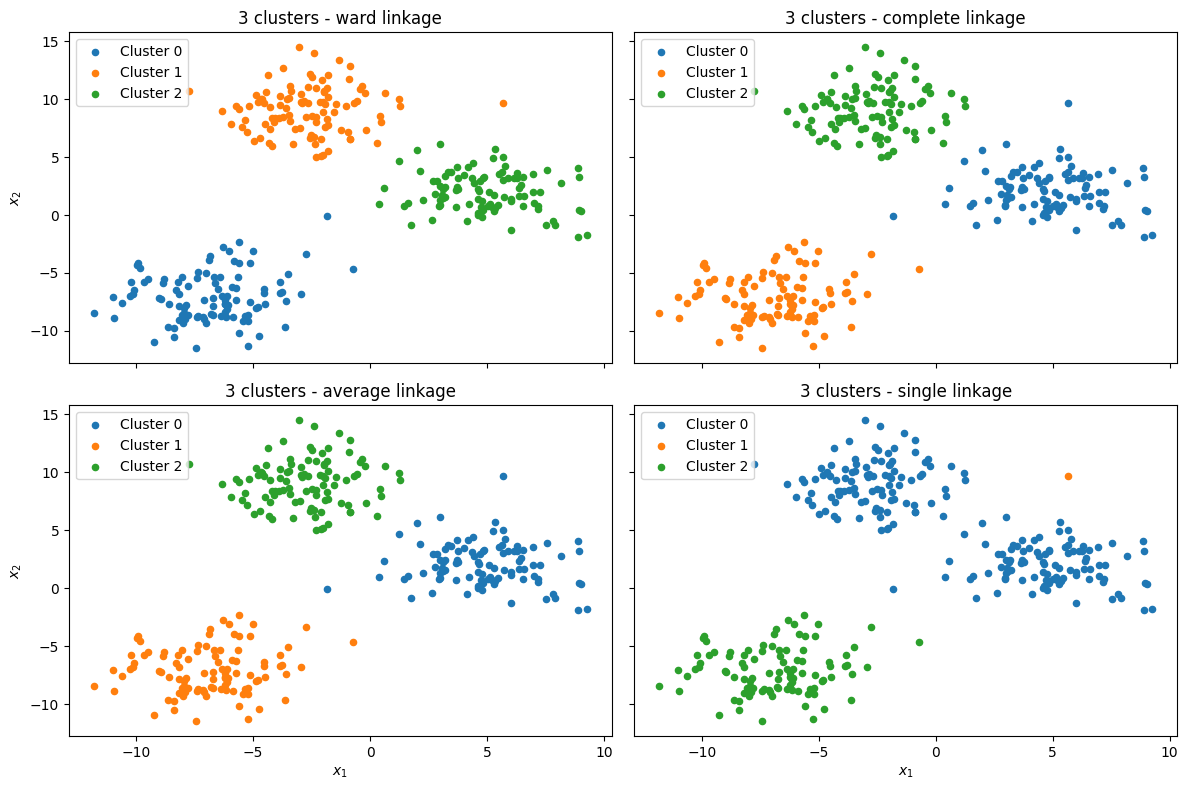

In [11]:
from sklearn.cluster import AgglomerativeClustering


linkages = ["ward", "complete", "average", "single"]
idx = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}

fig, axs = plt.subplots(2, 2, figsize = (12, 8), sharex = True, sharey = True)

for l, linkage in enumerate(linkages):
    hierarchical_cluster = AgglomerativeClustering(n_clusters = 3, linkage = linkage)
    hierarchical_cluster.fit(X)
    hierarchical_cluster.labels_


    df.loc[:, "cluster"] = hierarchical_cluster.labels_
    for i in range(3):
        df[df.cluster == i].plot.scatter(x = "x_1", y = "x_2", c = colors[i], ax = axs[idx[l]], label = f"Cluster {i}")
    axs[idx[l]].set_xlabel(r"$x_1$")
    axs[idx[l]].set_ylabel(r"$x_2$")
    axs[idx[l]].set_title(f"3 clusters - {linkage} linkage")

fig.tight_layout()

In addition to K-means and hierarchical clustering, other clustering methods exist. Among others, the HDBSCAN algorithm is considered state-of-the-art today. Since this can be interpreted as a further development of the DBSCAN algorithm, it would make sense to look at both algorithms in the self-study or another course. An essential difference of these two algorithms is the possibility to identify observations as outliers and not to assign a cluster. This possibility is neither given by K-means nor by hierarchical clustering, because all observations are always assigned to clusters. However, it cannot be assumed that a certain algorithm dominates the other methods. The appropriate choice of the cluster algorithm always depends on the given data and field of study. Furthermore, it makes sense to compare several methods for the same data set in order to be able to assess how much the chosen model influences the assignment and thus the own analysis. 

## Case study: Firms clusters - clustered by firm variables - and their future financial performance

In this example, we take a look at an experiment with a real life example in finance. We are going to use the K-means clustering algorithm. The data sample includes companies from the S\&P 500 over a year. For each company, we have firm variables and the monthly return of the company's stock price. The firm variables for each month are:

* size: the natural log of the company's market capitalization (outstanding shares multiplied with the share price)
* btm: the ratio of a company's book equity value (assets minus liabilities) to its market capitalization
* esg: the ESG score provided by Eikon Refinitiv to approximate how much a company is exposed to firm risk related to environmental, social or governance issues
* momentum: the return from the past month

In [12]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/fda_cluster_data_sp500.csv", sep = ";")
df.loc[:, "Date"] = pd.to_datetime(df["Calc Date"], dayfirst=True)
df.drop(["Calc Date"], axis = 1, inplace = True)
df.rename(
    {
        "1 Month Total Return": "r_t",
        "Issue Market Cap": "mcap",
        "Total Assets, Reported": "assets",
        "Total Liabilities": "liabilities",
        "ESG Score": "esg"
    },
    axis = 1, 
    inplace = True
)
df.loc[:, "equity"] = df["assets"] - df["liabilities"]
df.loc[:, "btm"] = df["equity"] / df["mcap"]
df.loc[:, "size"] = df["mcap"].apply(np.log)
df.loc[:, "momentum"] = df.get(["RIC", "r_t"]).groupby("RIC").shift(1)
df = df.get(["Date", "RIC", "size", "btm", "esg", "momentum", "r_t"])
df = df.dropna()
df.head()

,Date,RIC,size,btm,esg,momentum,r_t
1,2023-11-30,POOL.OQ,23.321058,0.091945,48.74,-11.33,10.05
2,2023-12-31,POOL.OQ,23.459046,0.080094,50.64,10.05,14.80
3,2024-01-31,POOL.OQ,23.387687,0.086018,50.64,14.80,-6.89
4,2024-02-29,POOL.OQ,23.449700,0.085925,50.64,-6.89,3.83
5,2024-03-31,POOL.OQ,23.465972,0.084538,50.64,3.83,1.63


As soon as we exceed three dimensions, we can not visualize the data. For the moment, let us only use up to two variables for clustering such that we can visually observer what is going on. Below we examine all possible pair combinations for the four firm variables for the first month in our data set. We can see that no typical clusters can be observed.

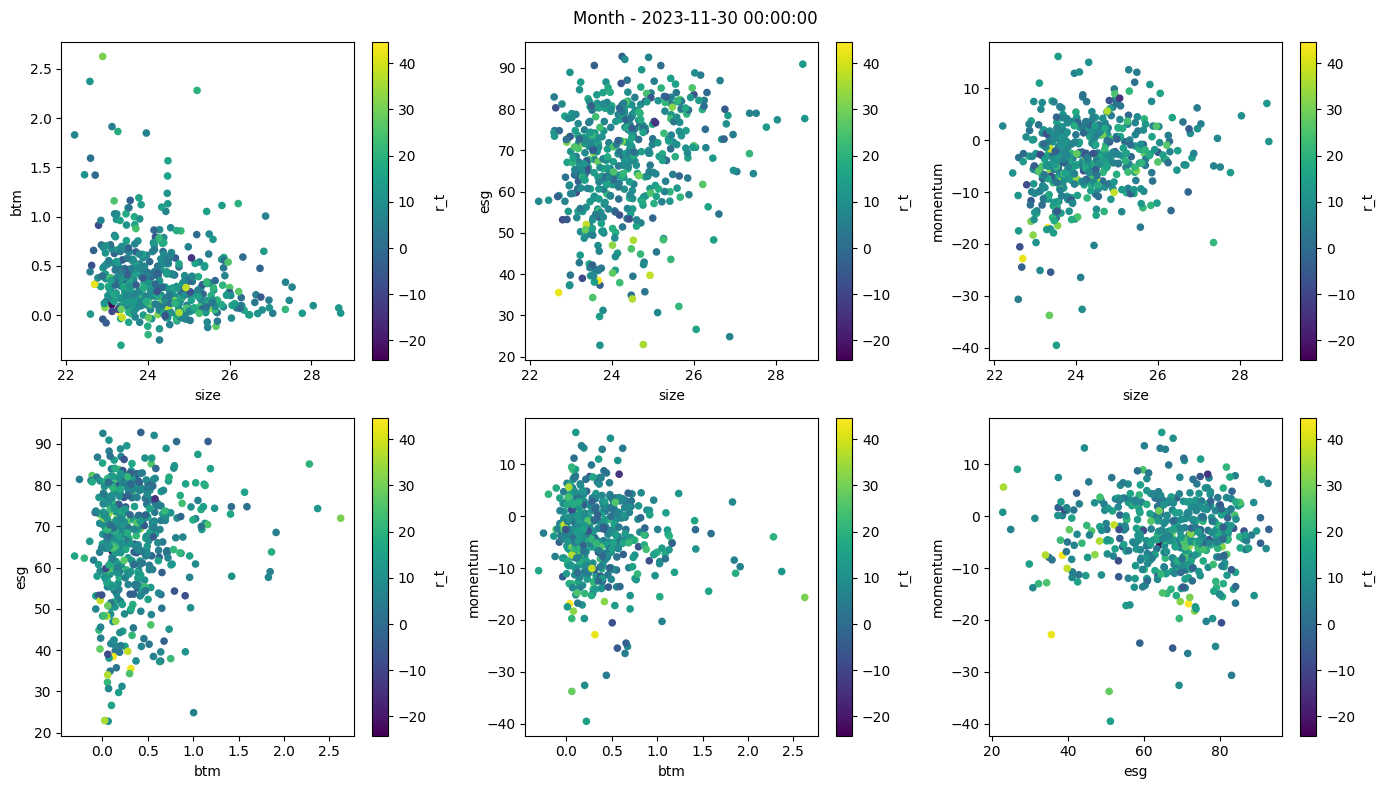

In [13]:
import matplotlib.pylab as plt

dates = df.Date.unique()
dt = next(iter(dates))
df_tmp = df[df.Date == dt]


fig, axs = plt.subplots(2, 3, figsize = (14, 8))
df_tmp.plot.scatter(x = "size", y = "btm", c = "r_t", ax = axs[0, 0], cmap = "viridis")
df_tmp.plot.scatter(x = "size", y = "esg", c = "r_t", ax = axs[0, 1], cmap = "viridis")
df_tmp.plot.scatter(x = "size", y = "momentum", c = "r_t", ax = axs[0, 2], cmap = "viridis")
df_tmp.plot.scatter(x = "btm", y = "esg", c = "r_t", ax = axs[1, 0], cmap = "viridis")
df_tmp.plot.scatter(x = "btm", y = "momentum", c = "r_t", ax = axs[1, 1], cmap = "viridis")
df_tmp.plot.scatter(x = "esg", y = "momentum", c = "r_t", ax = axs[1, 2], cmap = "viridis")
fig.suptitle(f"Month - {dt}")
fig.tight_layout()
plt.show()

Nevertheless, let us try to group the data by the size and esg variable. Below is a plot which exhibits the average silhouette scores for all companies for an increasing number of clusters. Overall, if we cluster the data, it seems to work best for three clusters.

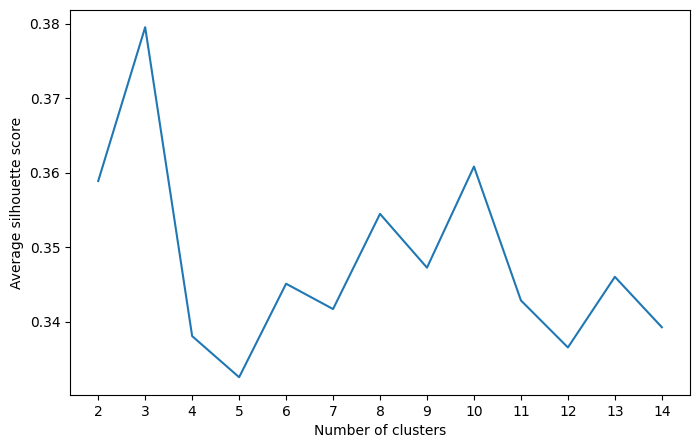

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import matplotlib.pylab as plt

df_tmp = df[df.Date == dt]
cluster_data = df_tmp.get(["size", "esg"]).copy()
cluster_data = cluster_data.reset_index(drop = True)
scaler = StandardScaler()
cluster_data_s = scaler.fit_transform(cluster_data)

scores = []
max_clusters = 15
for n_cluster in range(2, max_clusters): 
    kmeans = KMeans(n_clusters = n_cluster, n_init = "auto", random_state = 42)
    kmeans.fit(cluster_data_s)
    silhouette_scores = silhouette_samples(cluster_data_s, kmeans.labels_, metric = "euclidean")
    scores.append(silhouette_scores.mean())

fig, axs = plt.subplots(figsize = (8, 5))
axs.plot(scores)
axs.set_xticks(list(range(max_clusters-2)), [f"{i}" for i in range(2, max_clusters)])
axs.set_xlabel("Number of clusters")
axs.set_ylabel("Average silhouette score")
plt.show()

The left figure shows us that the data set is roughly split into two groups with either higher or lower ESG risks. The low ESG risk group is further split by size. Nevertheless, we can see that many companies are similar to companies from other clusters. This is especially true at the edges of each cluster and due to the fact that no isolated company group does exist. 

To alter this approach in a domain-specific way, we do the following. For each cluster we determine the silhouette scores for every company and rank these values. Within each cluster, we only keep 20 companies with the highest scores (lowest rank). All other companies are treated as outliers and do not belong to their original cluster anymore. The right figure exhibits the results for this procedure. Even though we exclude many companies by this approach, we improve the clusters such that companies between clusters are more different to each other than under the standard approach. 

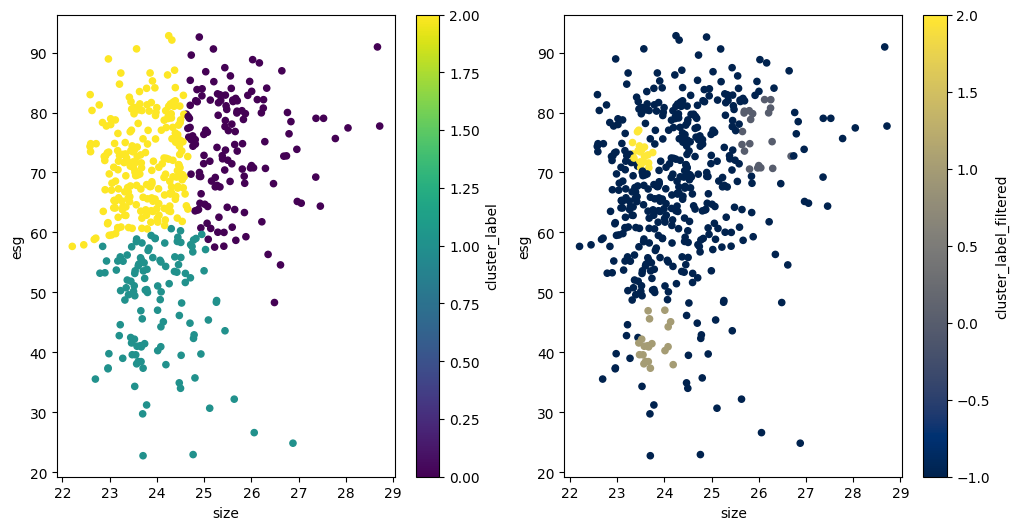

In [15]:
import matplotlib.pylab as plt

keep_topn = 20
cluster_data_tmp = cluster_data.copy()

kmeans = KMeans(n_clusters = 3, n_init = "auto", random_state = 42)
kmeans.fit(cluster_data_s)

cluster_data_tmp.loc[:, "cluster_label"] = kmeans.labels_
cluster_data_tmp.loc[:, "score"] = silhouette_samples(cluster_data_s, kmeans.labels_, metric = "euclidean")

cluster_data_tmp['rank'] = cluster_data_tmp.groupby('cluster_label')['score'].rank(method='first', ascending=False)
cluster_data_tmp['cluster_label_filtered'] = cluster_data_tmp.apply(lambda row: row['cluster_label'] if row['rank'] <= keep_topn else -1, axis=1)
cluster_data_tmp[cluster_data_tmp.cluster_label !=-1]

fig, axs = plt.subplots(1, 2, figsize = (12, 6))
cluster_data_tmp.plot.scatter(x = "size", y = "esg", c = "cluster_label", cmap = "viridis", ax = axs[0])
cluster_data_tmp.plot.scatter(x = "size", y = "esg", c = "cluster_label_filtered", cmap = "cividis", ax = axs[1])

plt.show()


The improvement can be quantified by higher average silhouette scores for all number of clusters as demonstrated below. 

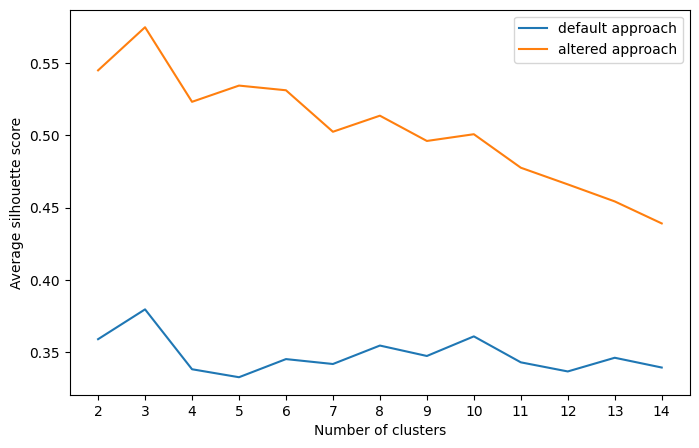

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import matplotlib.pylab as plt

df_tmp = df[df.Date == dt]
cluster_data = df_tmp.get(["size", "esg"]).copy()
cluster_data = cluster_data.reset_index(drop = True)
scaler = StandardScaler()
cluster_data_s = scaler.fit_transform(cluster_data)
keep_topn = 20

scores, filtered_scores = [], []
max_clusters = 15
for n_cluster in range(2, max_clusters): 
    kmeans = KMeans(n_clusters = n_cluster, n_init = "auto", random_state = 42)
    kmeans.fit(cluster_data_s)
    cluster_data_tmp = cluster_data.copy()
    cluster_data_tmp.loc[:, "cluster_label"] = kmeans.labels_
    cluster_data_tmp.loc[:, "score"] = silhouette_samples(cluster_data_s, kmeans.labels_, metric = "euclidean")

    cluster_data_tmp['rank'] = cluster_data_tmp.groupby('cluster_label')['score'].rank(method='first', ascending=False)
    cluster_data_tmp['cluster_label_filtered'] = cluster_data_tmp.apply(lambda row: row['cluster_label'] if row['rank'] <= keep_topn else -1, axis=1)

    silhouette_scores = silhouette_samples(cluster_data_s, kmeans.labels_, metric = "euclidean")
    scores.append(cluster_data_tmp.score.mean())
    filtered_scores.append(cluster_data_tmp[cluster_data_tmp.cluster_label_filtered != -1].score.mean())

fig, axs = plt.subplots(figsize = (8, 5))
axs.plot(scores, label = "default approach")
axs.plot(filtered_scores, label = "altered approach")
axs.set_xticks(list(range(max_clusters-2)), [f"{i}" for i in range(2, max_clusters)])
axs.set_xlabel("Number of clusters")
axs.set_ylabel("Average silhouette score")
axs.legend()
plt.show()

To examine the economic meaning behind each cluster, we do the following. For a given month, we cluster the data into three clusters. We only keep the 20 companies with the highest silhouette scores per cluster. For each of these clusters, we build a equally weighted portfolio and track its portfolio mean in the month after clustering. For comparability, the cluster centers are initialized with the cluster centers from the month before (except for the first month in the time series, here centers are initialized randomly). While portfolio members over time can change, each cluster portfolio is representing a group with characteristic firm variables that are different for each cluster.

In [17]:
df.loc[:, "cluster"] = np.nan
n_cluster = 3

for i, (date, df_tmp) in enumerate(df.groupby("Date")):
    cluster_data = df_tmp.get(["size", "btm", "esg", "momentum"]).copy()
    cluster_data = cluster_data
    scaler = StandardScaler()
    cluster_data_s = scaler.fit_transform(cluster_data)

    if i == 0:
        inits = "k-means++"
    else:
        inits = last_cluster_centroids
    

    kmeans = KMeans(n_clusters = n_cluster, init = inits, random_state = 42)
    kmeans.fit(cluster_data_s)
    last_cluster_centroids = kmeans.cluster_centers_
    cluster_data_tmp = cluster_data.copy()
    cluster_data_tmp.loc[:, "cluster_label"] = kmeans.labels_
    cluster_data_tmp.loc[:, "score"] = silhouette_samples(cluster_data_s, kmeans.labels_, metric = "euclidean")

    cluster_data_tmp['rank'] = cluster_data_tmp.groupby('cluster_label')['score'].rank(method='first', ascending=False)
    cluster_data_tmp['cluster_label_filtered'] = cluster_data_tmp.apply(lambda row: row['cluster_label'] if row['rank'] <= keep_topn else -1, axis=1)

    df.loc[cluster_data_tmp.index, "cluster"] = cluster_data_tmp.cluster_label_filtered
    df.loc[cluster_data_tmp.index, "score"] = cluster_data_tmp.score
    df["r_t_next_month"] = df["r_t"].shift(-1)

tuples = []
for dt in df.Date.unique():
    for c in range(n_cluster):
        tuples.append((dt, c))


cluster_portfolios = pd.DataFrame(index = pd.MultiIndex.from_tuples(tuples, names = ["Date", "cluster"]), columns = ["size", "btm", "esg", "momentum", "r_t_next_month"])

for dt, df_tmp in df.groupby("Date"):
    cluster_characteristics_per_cluster_tmp = df_tmp[df_tmp.cluster != -1].groupby("cluster").apply(lambda x: x.get(["size", "btm", "esg", "momentum", "r_t_next_month"]).mean(), include_groups = False)
    cluster_portfolios.loc[(dt, [0, 1, 2]), :] = cluster_characteristics_per_cluster_tmp.loc[[0, 1, 2], :].values

cluster_portfolios.unstack(level = "cluster")

size                             btm                      \
cluster             0          1          2         0         1         2   
Date                                                                        
2023-11-30  25.864559  23.371193  23.745521  0.142162  0.804323  0.160931   
2023-12-31   25.99574  23.492157  23.825408  0.103048  0.690868  0.150594   
2024-01-31  25.942305  23.710426  23.781515  0.132962  0.909979   0.13652   
2024-02-29   26.10786  23.665211  23.871462  0.120501  0.784601  0.170862   
2024-03-31  25.909333  23.530945  23.826689  0.109763  0.748851  0.151105   
2024-04-30  26.065302  23.627082  23.693768  0.138102  0.771961  0.188995   
2024-05-31   26.17012  23.661488  23.711707  0.117693  0.730074  0.204809   
2024-06-30  26.021945  23.501917   23.80336  0.111444  0.798867  0.171519   
2024-07-31  26.152214  23.661003  24.031522  0.077804  0.571051  0.134727   
2024-08-31  26.168559  23.609787  23.978566  0.102274  0.639054  0.132902   
2024-09-30  26.096877  23.649679  23.953981  0.103124  0.700148  0.142866   
2024-10-31  25.559521  23.852237  23.820419  0.092565  0.852176  0.174065   
2024-11-30  25.910007  23.396797   24.23859  0.106654  0.695055  0.151611   

                esg                   momentum                    \
cluster           0        1        2        0        1        2   
Date                                                               
2023-11-30   81.441  74.9955  45.7645   -1.357 -11.4665  -1.3225   
2023-12-31   78.537  72.9035   46.142   9.4365    6.979  13.1415   
2024-01-31  80.4775  76.1235  47.2125   4.4825  12.6385    7.608   
2024-02-29   77.876   78.428   48.316   4.8225   -5.196   -1.119   
2024-03-31  78.6765  74.4255  46.0305   3.7625   -2.951   8.1745   
2024-04-30  78.0085   75.106   44.978   1.9895  11.4645    1.372   
2024-05-31   78.298  74.4565  48.6345    -3.29  -1.1175  -11.828   
2024-06-30   77.815  75.9275    44.96   1.5695    4.328  -3.6015   
2024-07-31    77.84  76.9945   41.403    4.316   -2.301    1.272   
2024-08-31  76.9315  76.4895  42.9735   0.3725   9.4755   3.8915   
2024-09-30  78.3535  75.7085  43.5795   4.9905   0.7025   4.4235   
2024-10-31   80.024  75.3875  44.6335     5.42  -1.2815   1.1205   
2024-11-30   80.193   71.634  43.8795  -1.7845   -9.424    4.438   

           r_t_next_month                  
cluster                 0       1       2  
Date                                       
2023-11-30         5.1525  12.753  3.6115  
2023-12-31         2.0345 -4.5525   3.708  
2024-01-31         3.1955   -0.86  10.121  
2024-02-29         1.9405   6.861   2.852  
2024-03-31         -5.511  -3.914  -9.134  
2024-04-30         2.4915   6.438   1.106  
2024-05-31         2.4405  1.6015  -2.947  
2024-06-30         2.6685   6.341  8.9085  
2024-07-31          3.773   1.682   0.456  
2024-08-31         1.8565   1.276  4.1005  
2024-09-30         -2.635 -2.1265 -4.2895  
2024-10-31         5.0025  4.0005   5.112  
2024-11-30         12.546  11.957   9.124

The figure below visualizes the average firm characteristic per cluster. For instance, cluster 0 seems to have larger companies with a lower book to market ratio and a better ESG performance. The momentum variable seems not to play an important role for clustering as its average values for each cluster are rather similar between clusters. 

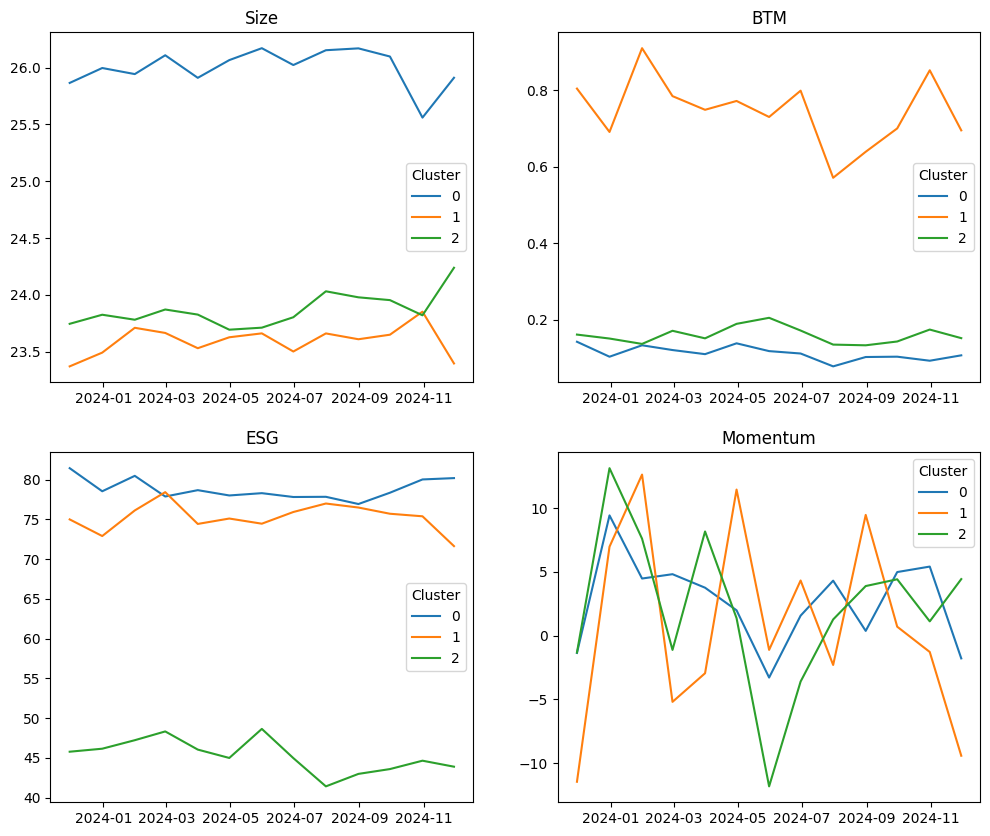

In [18]:
fig, axs = plt.subplots(2, 2, figsize = (12, 10))
for cl, data in cluster_portfolios.groupby(level = "cluster"):
    axs[0, 0].plot(data.index.get_level_values(0), data["size"], label = cl)
    axs[0, 1].plot(data.index.get_level_values(0), data["btm"], label = cl)
    axs[1, 0].plot(data.index.get_level_values(0), data["esg"], label = cl)
    axs[1, 1].plot(data.index.get_level_values(0), data["momentum"], label = cl)
axs[0, 0].set_title("Size")
axs[0, 1].set_title("BTM")
axs[1, 0].set_title("ESG")
axs[1, 1].set_title("Momentum")
axs[0, 0].legend(title = "Cluster")
axs[0, 1].legend(title = "Cluster")
axs[1, 0].legend(title = "Cluster")
axs[1, 1].legend(title = "Cluster")
plt.show()

The graph below shows the cumulative (left) and monthly (right) portfolio returns. Cluster 1 has the highest increase in value of the year. Financial market theory tells us that this portfolio should also be more risky than the other two portfolios. Let us take a look at the descriptive statistics for all three portfolios below.

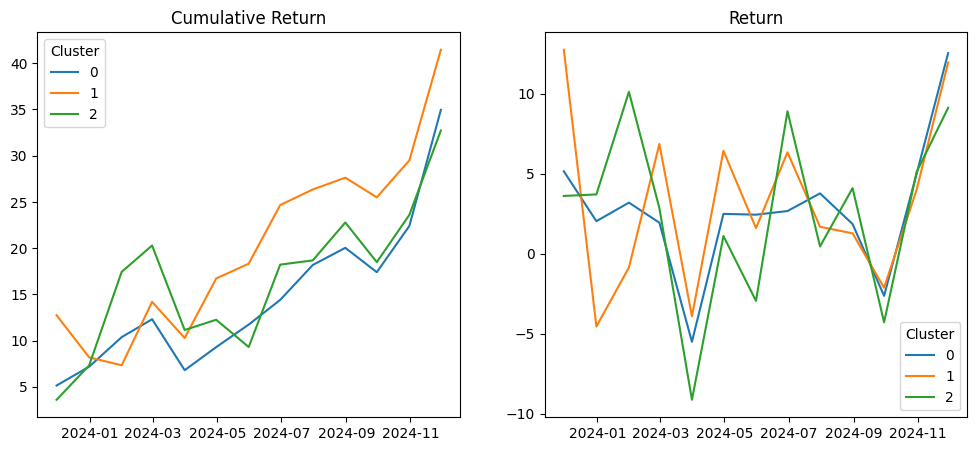

In [19]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
for cl, data in cluster_portfolios.groupby(level = "cluster"):
    axs[0].plot(data.index.get_level_values(0), data["r_t_next_month"].cumsum(), label = cl)
    axs[1].plot(data.index.get_level_values(0), data["r_t_next_month"], label = cl)

axs[0].set_title("Cumulative Return")
axs[1].set_title("Return")
axs[0].legend(title = "Cluster")
axs[1].legend(title = "Cluster")

The cluster 2 portfolio is not promising for any investor as it has the lowest average return and the highest risk (higher standard deviation, highest loss, lowest 5\% quantile). However, the financial performance of cluster 0 and cluster 1 is in line with financial market theory. Except for the highest loss, cluster 0 portfolio is less profitable but also less risky (lower standard deviation, higher 5\% quantile). 

In [20]:
desriptives_portfolio_returns = cluster_portfolios.groupby(level = "cluster").apply(lambda x: x.get(["r_t_next_month"]).astype(float).describe(percentiles = [0.05, 0.95]))
desriptives_portfolio_returns.unstack()

r_t_next_month                                                       \
                 count      mean       std     min      5%     50%      95%   
cluster                                                                       
0                 13.0  2.688885  4.157132 -5.5110 -3.7854  2.4915   8.1099   
1                 13.0  3.189000  5.526182 -4.5525 -4.1694  1.6820  12.2754   
2                 13.0  2.517615  5.571227 -9.1340 -6.2273  3.6115   9.5228   

                 
            max  
cluster          
0        12.546  
1        12.753  
2        10.121